# Business Understanding

## Analysis

The analysis is based on the data published by US Forest Service (USFS). Each observation contains information of type of tree coverage of a (30 x 30 meter cell) at four wilderness areas located in the Roosevelt National Forest of Northern Colorado.
Each cell contains a number of features including information about the soil type, elevation, and sunlight conditions, and there are a total of 7 possible types of trees. 
 
These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

The purpose of our analysis is to determine a model based on those categorical features and provide our customer with a tool to identify possible areas to grow Lodgepole Pine with the least human intervention. Our customer would like to explore areas outside this particular forest, therefore we would remove from the dataset the relevant columns regarding specific areas of this forest and check if we obtain a good prediction model.

# Data Understanding

## Imports

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
from Classification import Classification
from Ensemble import Ensemble
from IPython.display import display
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO 
from subprocess import call
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report 
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from yellowbrick.model_selection import feature_importances

In [2]:
pd.set_option('display.max_columns',999)

In [3]:
df = pd.read_csv("covtype.csv")

## Sampling

In [4]:
df= df.apply(lambda x: x.sample(n=100000, replace = True, random_state = 1))

In [5]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
128037,2771,27,11,0,0,1880,215,217,137,2089,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
491755,2889,64,9,218,84,685,229,221,125,930,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
470924,3095,84,7,0,0,1167,230,228,131,2140,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
491263,3075,140,14,240,-6,866,240,235,122,1237,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
371403,3288,353,13,417,77,3439,196,216,157,2698,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [6]:
df.reset_index(drop=True,inplace=True)

## Exploratory Data Analysis

In [7]:
df.shape

(100000, 55)

In [8]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2960.503820,156.034500,14.09028,269.46504,46.577100,2356.821130,212.102240,223.450730,142.731840,1976.750600,0.448260,0.052070,0.436820,0.062850,0.005110,0.013210,0.008190,0.021030,0.002830,0.011460,0.0001,0.000230,0.001970,0.055920,0.020920,0.050340,0.030820,0.000870,0.0,0.005110,0.005940,0.003470,0.007140,0.015920,0.001420,0.058280,0.099710,0.035690,0.000870,0.004490,0.001990,0.001630,0.198840,0.051700,0.044320,0.09191,0.077430,0.002620,0.003300,0.00021,0.000460,0.025740,0.023680,0.015130,2.043550
std,279.781093,111.834835,7.49341,211.79849,58.301387,1559.597647,26.723596,19.748727,38.306991,1317.725934,0.497318,0.222169,0.495995,0.242694,0.071302,0.114174,0.090128,0.143485,0.053123,0.106437,0.0100,0.015164,0.044341,0.229768,0.143117,0.218647,0.172831,0.029483,0.0,0.071302,0.076843,0.058805,0.084197,0.125167,0.037656,0.234273,0.299614,0.185517,0.029483,0.066857,0.044565,0.040341,0.399129,0.221422,0.205806,0.28890,0.267274,0.051119,0.057351,0.01449,0.021443,0.158359,0.152051,0.122071,1.387045
min,1866.000000,0.000000,0.00000,0.00000,-163.000000,0.000000,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2811.000000,59.000000,9.00000,108.00000,7.000000,1110.000000,198.000000,213.000000,119.000000,1022.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2998.000000,128.000000,13.00000,218.00000,30.000000,2010.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 55 columns):
Elevation                             100000 non-null int64
Aspect                                100000 non-null int64
Slope                                 100000 non-null int64
Horizontal_Distance_To_Hydrology      100000 non-null int64
Vertical_Distance_To_Hydrology        100000 non-null int64
Horizontal_Distance_To_Roadways       100000 non-null int64
Hillshade_9am                         100000 non-null int64
Hillshade_Noon                        100000 non-null int64
Hillshade_3pm                         100000 non-null int64
Horizontal_Distance_To_Fire_Points    100000 non-null int64
Wilderness_Area1                      100000 non-null int64
Wilderness_Area2                      100000 non-null int64
Wilderness_Area3                      100000 non-null int64
Wilderness_Area4                      100000 non-null int64
Soil_Type1                            100000 non-n

### Histogram of Target Variable

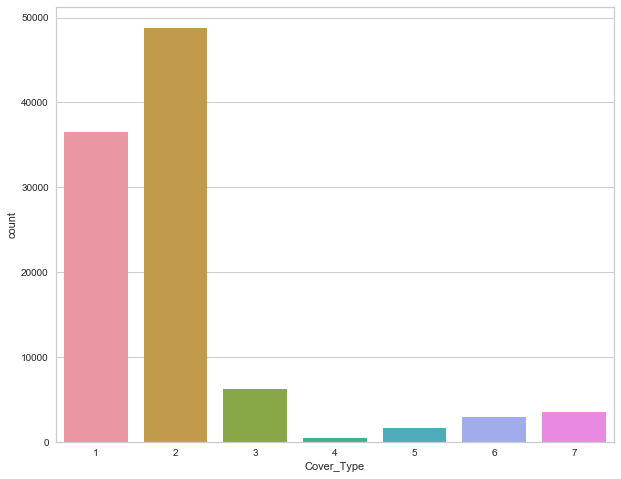

In [12]:
plt.figure(figsize=(10,8))
sns.countplot(df['Cover_Type'])

# Data Preparation

Splitting are target variable (Cover Type) into binary values "Lodgepole Pine" and "Not Lodgepole Pine".

In [13]:
df['Pine'] = df.Cover_Type.apply(lambda x: 1 if x == 2 else 0)

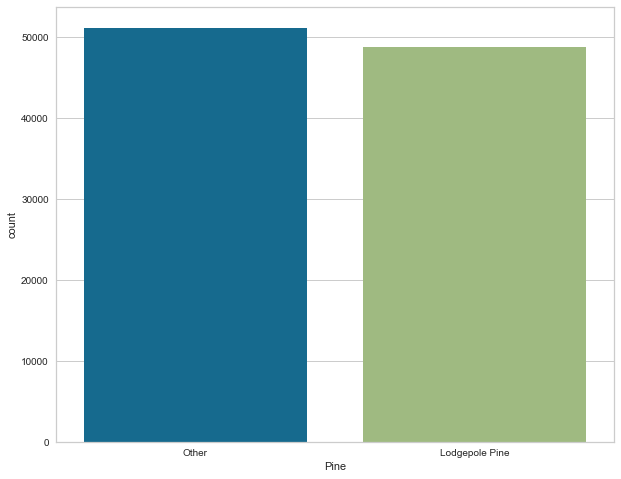

In [31]:
plt.figure(figsize=(10,8))
ax = sns.countplot(df['Pine'])
ax.set_xticklabels(["Other","Lodgepole Pine"])
plt.show()

## Splitting Variables and Plotting Their Relationships

In [15]:
df.drop(["Cover_Type"],axis=1,inplace=True)

In [16]:
cat_columns = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
               'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
               'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
               'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
               'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
               'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
               'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
               'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
               'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
               'Soil_Type39', 'Soil_Type40', 'Wilderness_Area1',
               'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4','Pine']

In [17]:
num_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
               'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
               'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
               'Horizontal_Distance_To_Fire_Points']

Let's plot some of the variables, 4 or 5 at the time as it will take longer or so small the images that will not be useful.

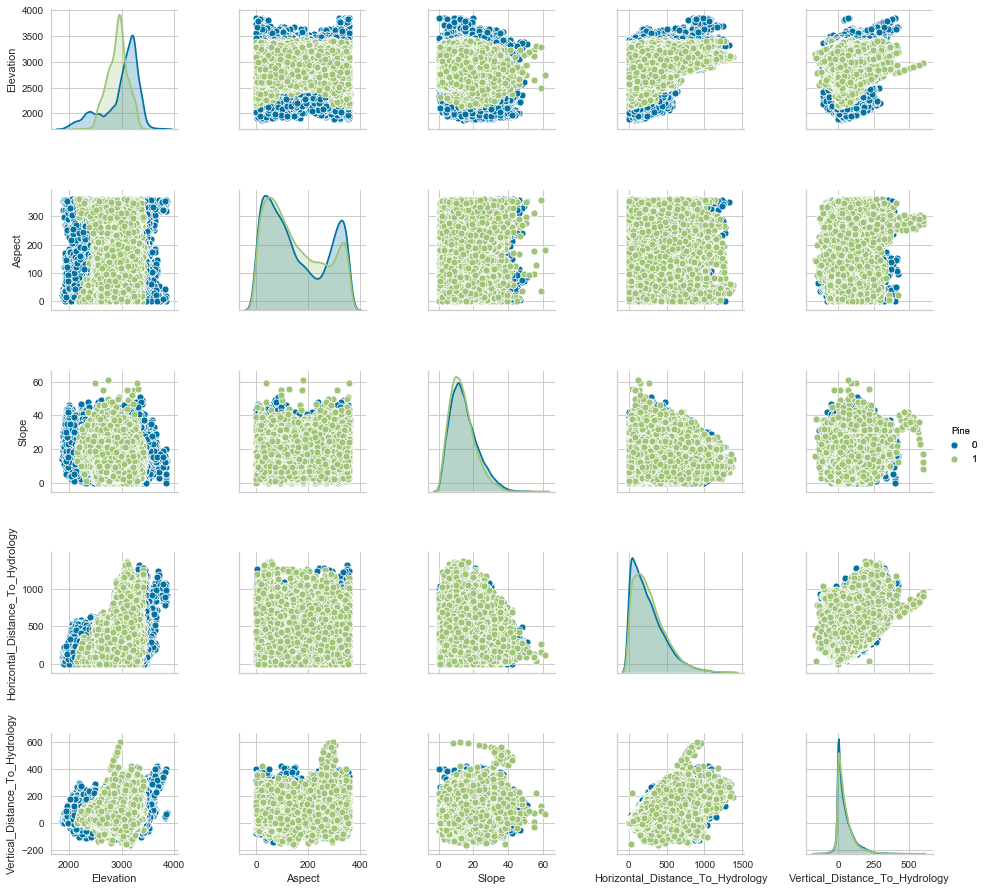

In [18]:
g = sns.pairplot(df,x_vars = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
               'Vertical_Distance_To_Hydrology'],y_vars= ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
               'Vertical_Distance_To_Hydrology'], hue="Pine")
g = g.add_legend()

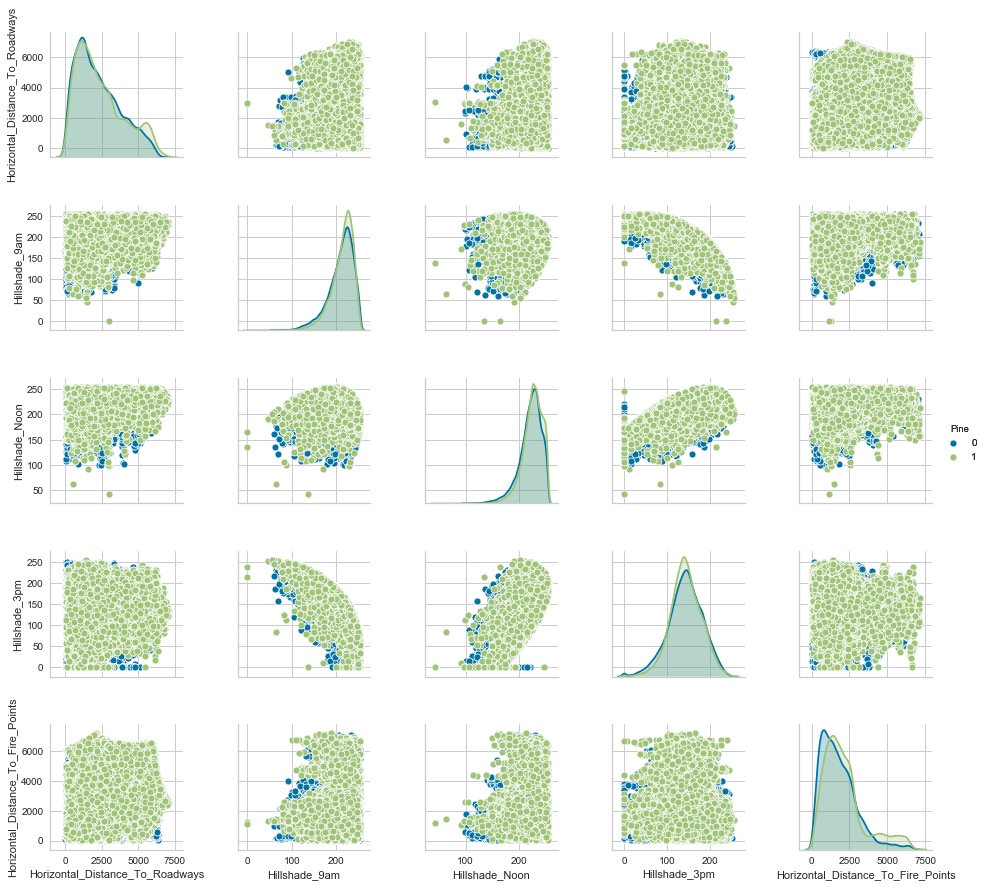

In [19]:
g = sns.pairplot(df,x_vars = ['Horizontal_Distance_To_Roadways',
               'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
               'Horizontal_Distance_To_Fire_Points'],y_vars= ['Horizontal_Distance_To_Roadways',
               'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
               'Horizontal_Distance_To_Fire_Points'], hue="Pine")
g = g.add_legend()

### Visualising Soil Types

In [22]:
def reverse_onehot(row):
    for c in df_soil.columns:
        if row[c]==1:
            return c  

In [23]:
df_soil = df.loc[:, 'Soil_Type1' : 'Soil_Type40']
df['Soil'] = df_soil.apply(reverse_onehot, axis=1)

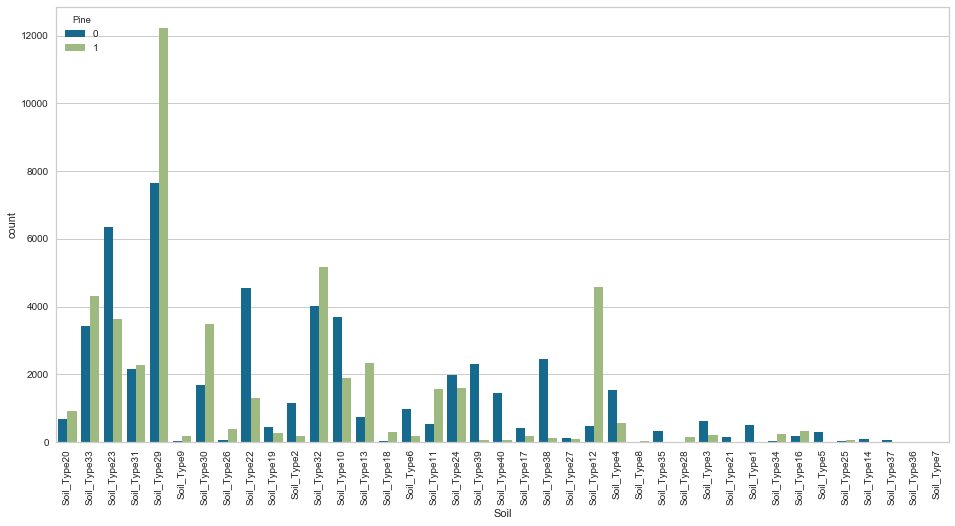

In [33]:
plt.figure(figsize=(16,8))
sns.countplot(x='Soil', hue='Pine',data= df)
plt.xticks(rotation=90)
plt.show()

### Visualising Wilderness Areas

In [34]:
df_wilderness = df.loc[:,'Wilderness_Area1':'Wilderness_Area4']

In [35]:
def reverse_onehot_w(row):
    for c in df_wilderness.columns:
        if row[c]==1:
            return c  

In [36]:
df['Wilderness_type'] = df_wilderness.apply(reverse_onehot_w, axis=1)

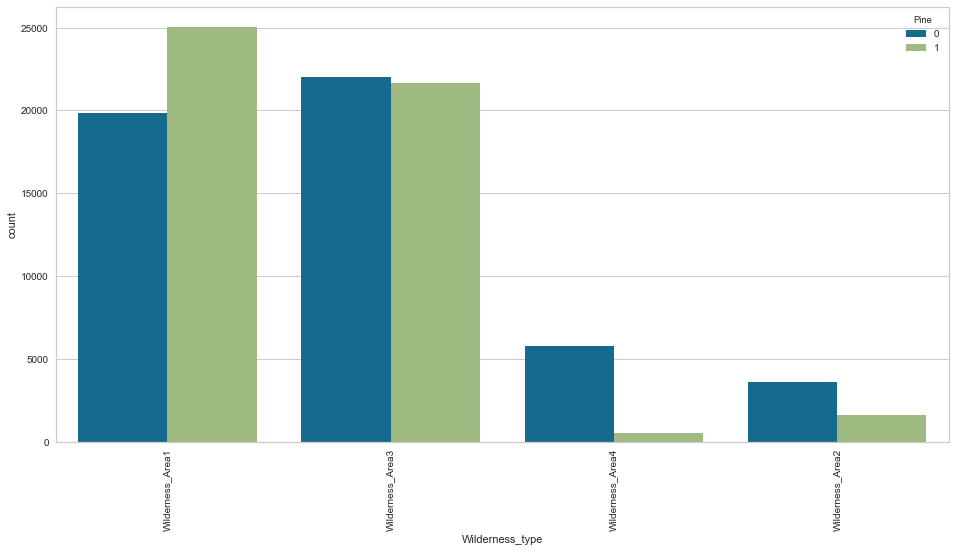

In [38]:
plt.figure(figsize=(16,8))
sns.countplot(x='Wilderness_type', hue='Pine',data= df)
plt.xticks(rotation=90)
plt.show()

Most of the Lodgepole Pine are concentrated in wilderness area 1 and 2.
We will run a baseline model with and without this particular wildereness areas to check the impact on the target variable.
All other features on the data set are categorical and independant of this particular forest. If we could obtain a good result without this feature our model can be applied to a different areas with similar climate.

In [41]:
df.drop(['Wilderness_type','Soil'],axis=1,inplace=True)

## Scaling

In [15]:
scaler = StandardScaler()

In [16]:
df_num_s = pd.DataFrame(scaler.fit_transform(df[num_columns]))

In [17]:
df_num_s.columns = df[num_columns].columns

In [18]:
df_plus_wild_s = pd.concat([df_num_s,df[cat_columns]],axis=1)

In [19]:
df_plus_wild_s.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Pine
0,-0.677332,-1.153801,-0.412402,-1.272277,-0.798906,-0.305735,0.108435,-0.326642,-0.149630,0.085185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,-0.255572,-0.822954,-0.679304,-0.242992,0.641890,-1.071962,0.632319,-0.124096,-0.462890,-0.794365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.480722,-0.644118,-0.946207,-1.272277,-0.798906,-0.762906,0.669740,0.230359,-0.306260,0.123888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.409237,-0.143377,-0.012048,-0.139119,-0.901820,-0.955906,1.043943,0.584814,-0.541205,-0.561387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,1.170550,1.761227,-0.145499,0.696585,0.521824,0.693887,-0.602551,-0.377278,0.372471,0.547347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [20]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Pine
0,2771,27,11,0,0,1880,215,217,137,2089,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2889,64,9,218,84,685,229,221,125,930,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3095,84,7,0,0,1167,230,228,131,2140,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3075,140,14,240,-6,866,240,235,122,1237,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3288,353,13,417,77,3439,196,216,157,2698,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [21]:
X_plus_wild = df.drop('Pine',1)
X_plus_wild_s = df_plus_wild_s.drop('Pine',1)
X = X_plus_wild.drop(['Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'],axis=1)
X_s = X_plus_wild_s.drop(['Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'],axis=1)

y = df["Pine"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=.25,random_state=42)


In [23]:
X_train_s, X_test_S, y_train, y_test = train_test_split(X_s,y,test_size=.25,random_state=42)

X_train_s, X_val_s, y_train, y_val = train_test_split(X_train_s,y_train,test_size=.25,random_state=42) 


In [24]:
X_plus_wild_train, X_plus_wild_test, y_train, y_test = train_test_split(X_plus_wild,y,test_size=.25,random_state=42)

X_plus_wild_train, X_plus_wild_val, y_train, y_val = train_test_split(X_plus_wild_train,y_train,test_size=.25,random_state=42)


In [25]:
X_plus_wild_train_s, X_plus_wild_test_s, y_train, y_test = train_test_split(X_plus_wild_s,y,test_size=.25,random_state=42)

X_plus_wild_train_s, X_plus_wild_val_s, y_train, y_val = train_test_split(X_plus_wild_train_s,y_train,test_size=.25,random_state=42)


In [26]:
X_plus_wild_train_s.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
97274,-2.789709,0.840221,0.254855,-0.375194,-0.078508,-1.066832,-1.089015,1.344360,1.599407,-0.307160,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
80546,1.027581,1.761227,1.856270,1.957224,1.465202,-0.676345,-1.874841,-2.200190,0.137525,-0.328409,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
92139,-2.510918,-1.064383,2.123172,-0.988988,-0.575926,-1.434237,-0.303188,-3.162282,-1.794246,-0.836104,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
26663,-0.037543,-0.688827,-1.213109,0.073348,-0.953277,-0.814202,0.520058,0.382268,-0.097420,0.139824,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
45662,0.566504,-1.234277,-0.812756,-0.988988,-0.695992,2.832270,0.108435,0.027813,0.085315,0.387980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [27]:
X_train_s.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
97274,-2.789709,0.840221,0.254855,-0.375194,-0.078508,-1.066832,-1.089015,1.344360,1.599407,-0.307160,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80546,1.027581,1.761227,1.856270,1.957224,1.465202,-0.676345,-1.874841,-2.200190,0.137525,-0.328409,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
92139,-2.510918,-1.064383,2.123172,-0.988988,-0.575926,-1.434237,-0.303188,-3.162282,-1.794246,-0.836104,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26663,-0.037543,-0.688827,-1.213109,0.073348,-0.953277,-0.814202,0.520058,0.382268,-0.097420,0.139824,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45662,0.566504,-1.234277,-0.812756,-0.988988,-0.695992,2.832270,0.108435,0.027813,0.085315,0.387980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Modelling

## Choosing a Method for K-Fold Cross Validation 

In [28]:
skf = StratifiedKFold(n_splits=5,random_state=42)

## Baseline Model (Logistic Regression)

We chose to use Logistic Regression as our baseline model.

### Baseline Model Including Wilderness Areas

In [30]:
baseline_plus_wild = Classification('Logistic Regression',X_plus_wild_train_s,X_plus_wild_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8243,0.8247


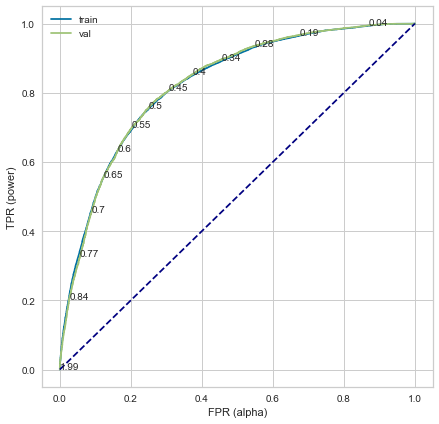

In [31]:
param_grid = {}
baseline_plus_wild.get_scores(param_grid,skf)

### Baseline Model

In [32]:
baseline = Classification('Logistic Regression',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8002,0.7983


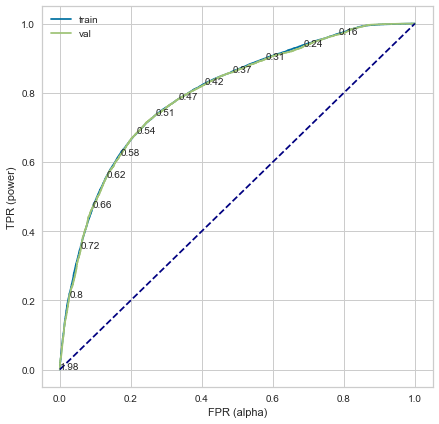

In [33]:
param_grid = {}
baseline.get_scores(param_grid,skf)

## Hyperparameter Tuning Logistic Regression

### Logistic Classifier Optimisation 1st Attempt

In [34]:
logistic1 = Classification('Logistic Regression',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8007,0.7987


The best hyperparameters are:  {'C': 1000, 'penalty': 'l2'} 



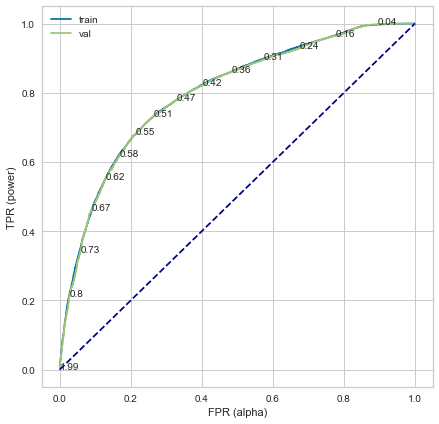

In [35]:
param_grid = {"penalty":['l1', 'l2'],            # l1 and l2 are different type of penalties  # Algorithm to use in the optimization problem
              "C":[0.01,0.1,1,10,100,1000,10000]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

logistic1.get_scores(param_grid,skf)

### Logistic Classifier Optimisation 2nd Attempt

In [36]:
logistic2 = Classification('Logistic Regression',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8007,0.7986


The best hyperparameters are:  {'C': 600, 'penalty': 'l2'} 



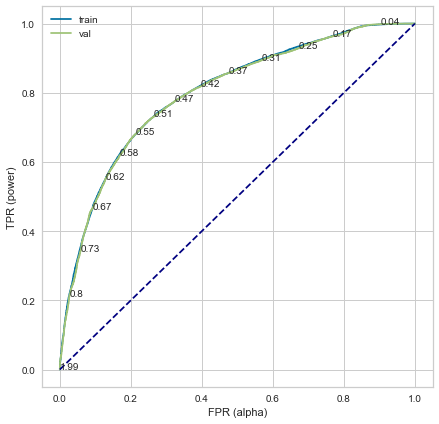

In [37]:
param_grid = {"penalty":['l1', 'l2'],            # l1 and l2 are different type of penalties  # Algorithm to use in the optimization problem
              "C":[400,600,1000,2000,3000,4000,5000]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

logistic2.get_scores(param_grid,skf)


### Logistic Classifier Optimisation 3rd Attempt

In [38]:
logistic3 = Classification('Logistic Regression',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8007,0.7986


The best hyperparameters are:  {'C': 600, 'penalty': 'l2'} 



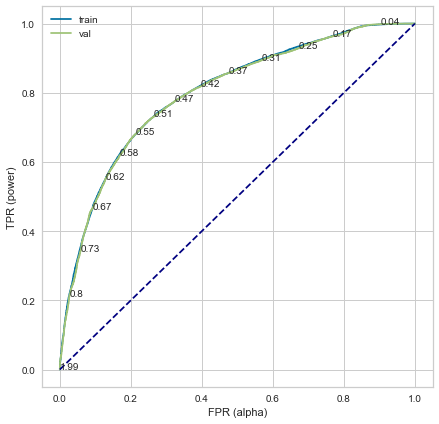

In [39]:
param_grid = {"penalty":['l1', 'l2'],            # l1 and l2 are different type of penalties  # Algorithm to use in the optimization problem
              "C":[500,550,600,650,700,750,800]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

logistic3.get_scores(param_grid,skf)

### Logistic Classifier Optimisation 4th Attempt

In [40]:
logistic4 = Classification('Logistic Regression',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8007,0.7987


The best hyperparameters are:  {'C': 610, 'penalty': 'l2'} 



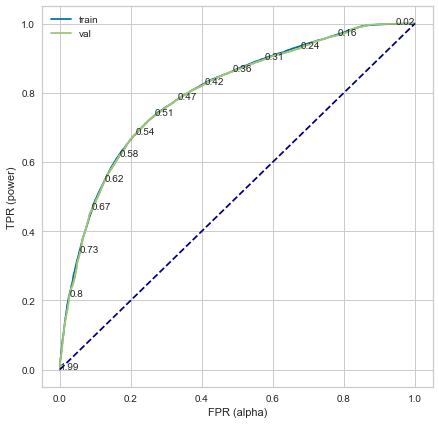

In [41]:
param_grid = {"penalty":['l1', 'l2'],            # l1 and l2 are different type of penalties  # Algorithm to use in the optimization problem
              "C":[580,590,600,610,620,630]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

logistic4.get_scores(param_grid,skf)

## Hyperparameter Tuning Decision Tree

### Decision Tree Optimisation 1st Attempt

In [42]:
dtree1 = Classification('Decision Tree',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.9762,0.9094


The best hyperparameters are:  {'max_depth': 35, 'min_samples_leaf': 10} 



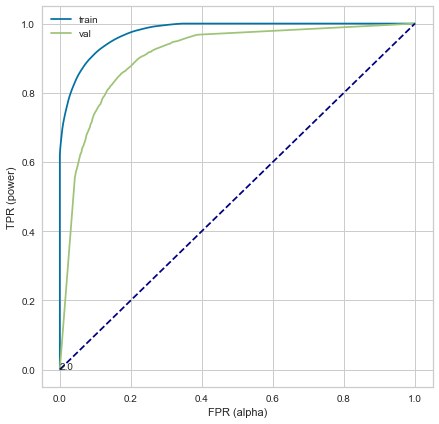

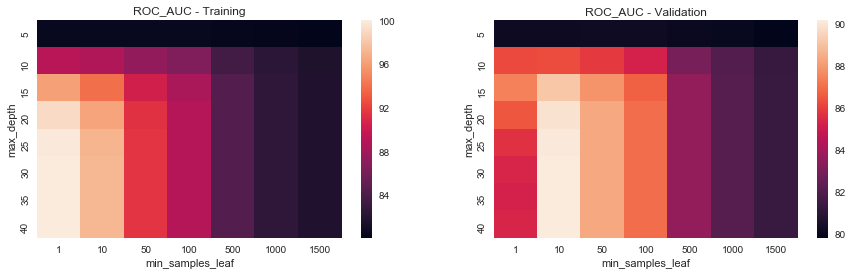

In [43]:
param_grid = {'max_depth':[5,10,15,20,25,30,35,40],            # The maximum depth of the tree
              'min_samples_leaf':[1,10,50,100,500,1000,1500]}  # The minimum number of samples required to be at a leaf node

dtree1.get_scores(param_grid,skf)
dtree1.opt_plots()

### Decision Tree Optimisation 2nd Attempt

In [44]:
dtree2 = Classification('Decision Tree',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.9762,0.9094


The best hyperparameters are:  {'max_depth': 33, 'min_samples_leaf': 10} 



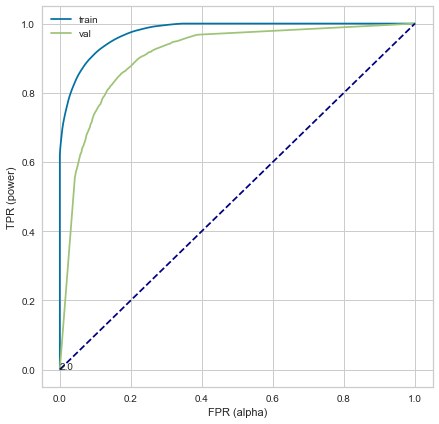

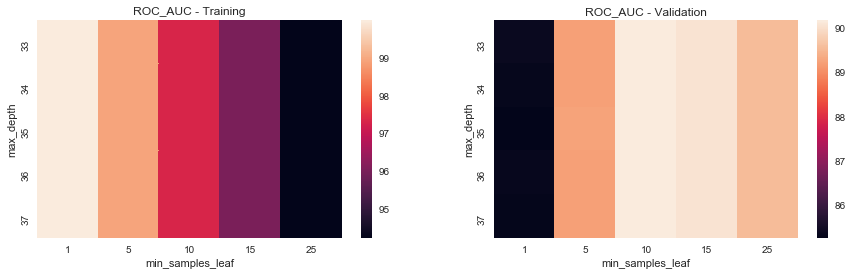

In [45]:
param_grid = {'max_depth':[33,34,35,36,37],         # The maximum depth of the tree
              'min_samples_leaf':[1,5,10,15,25]}  # The minimum number of samples required to be at a leaf node

dtree2.get_scores(param_grid,skf)
dtree2.opt_plots()

### Decision Tree Optimisation 3rd Attempt

In [46]:
dtree3 = Classification('Decision Tree',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.9762,0.9094


The best hyperparameters are:  {'max_depth': 33, 'min_samples_leaf': 10} 



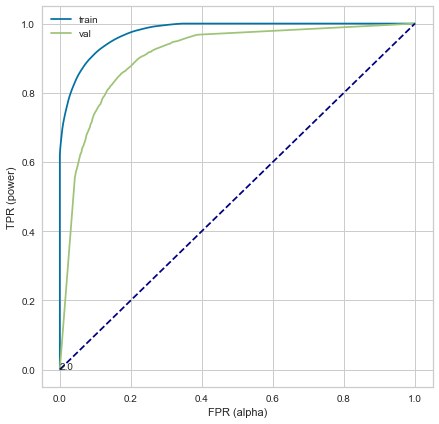

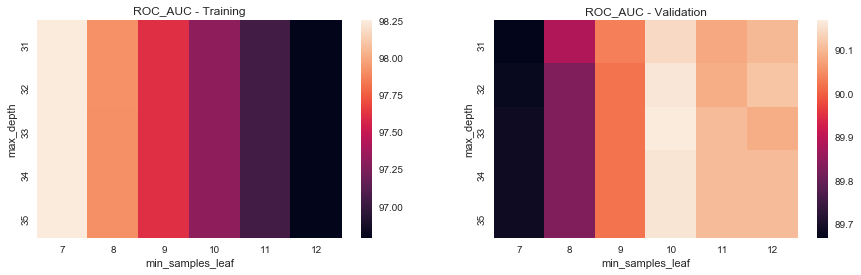

In [47]:
param_grid = {'max_depth':[31,32,33,34,35],         # The maximum depth of the tree
              'min_samples_leaf':[7,8,9,10,11,12]}  # The minimum number of samples required to be at a leaf node

dtree3.get_scores(param_grid,skf)
dtree3.opt_plots()

## Hyperparameter Tuning Random Forest

### Random Forest Optimisation 1st Attempt

In [48]:
ran_forest1 = Classification('Random Forest',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Random Forest,1.0,0.9617


The best hyperparameters are:  {'max_depth': 40, 'min_samples_leaf': 1} 



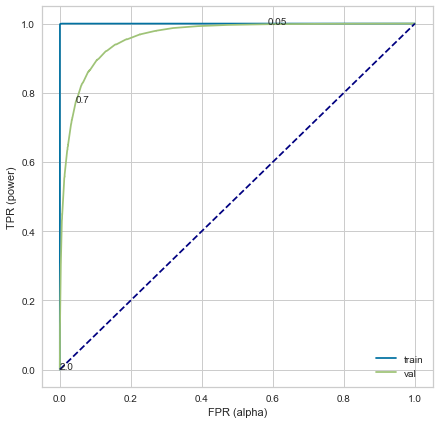

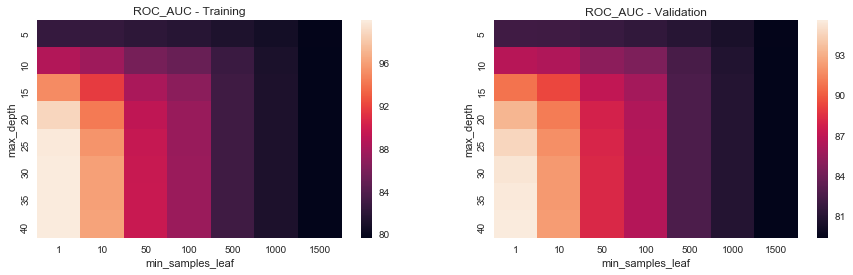

In [49]:
param_grid = {'max_depth':[5,10,15,20,25,30,35,40],           # The maximum depth of the tree
              'min_samples_leaf':[1,10,50,100,500,1000,1500]} # The minimum number of samples required to be at a leaf node

ran_forest1.get_scores(param_grid,skf)
ran_forest1.opt_plots()

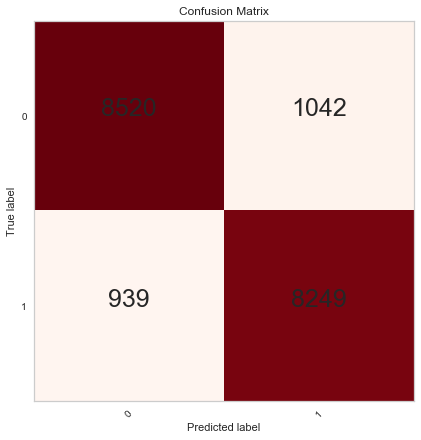

In [50]:
ran_forest1.show_conf_matrix()

### Random Forest Optimisation 2nd Attempt

In [51]:
ran_forest2 = Classification('Random Forest',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Random Forest,1.0,0.9622


The best hyperparameters are:  {'max_depth': 43, 'min_samples_leaf': 1} 



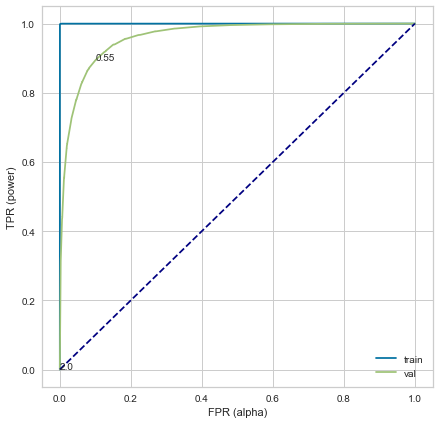

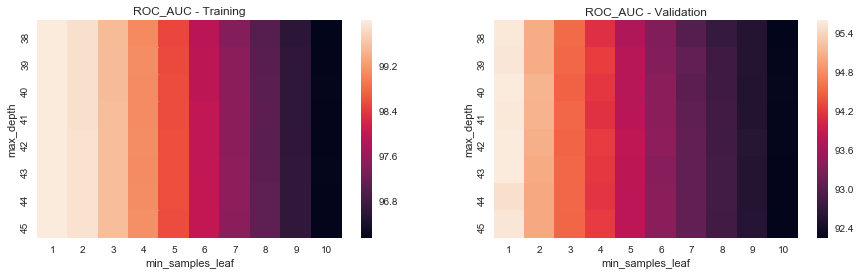

In [52]:
param_grid = {'max_depth':[38,39,40,41,42,43,44,45],           # The maximum depth of the tree
              'min_samples_leaf':range(1,10+1)}                                              # The minimum number of samples required to be at a leaf node

ran_forest2.get_scores(param_grid,skf)
ran_forest2.opt_plots()

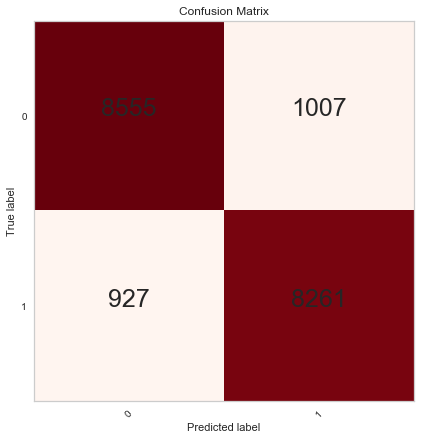

In [53]:
ran_forest2.show_conf_matrix()

## Hyperparameter Tuning Support Vector Machines

### SVC Optimisation 1st Attempt

In [54]:
svm1 = Classification('SVM',X_train_s,X_val_s,y_train,y_val)

In [55]:
# param_grid = {}       

# svm1.get_scores(param_grid,skf)

SVM is not suitable for large datasets because of its high training time.

## AdaBoost Classifier

### AdaBoost Applied to Logistic Regression

In [57]:
estimators = logistic4.best_model
adaboost_log_reg = Ensemble("AdaBoost", estimators, X_train_s, X_val_s, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,AdaBoost,0.7719,0.7678


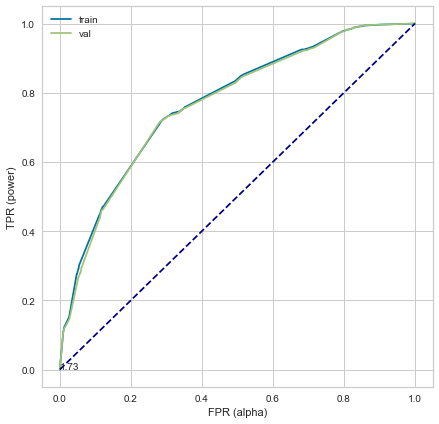

In [58]:
adaboost_log_reg.get_scores({}, skf)

### AdaBoost Applied to Decision Tree

In [59]:
estimators = dtree3.best_model
adaboost_dtree = Ensemble("AdaBoost", estimators, X_train_s, X_val_s, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,AdaBoost,1.0,0.9696


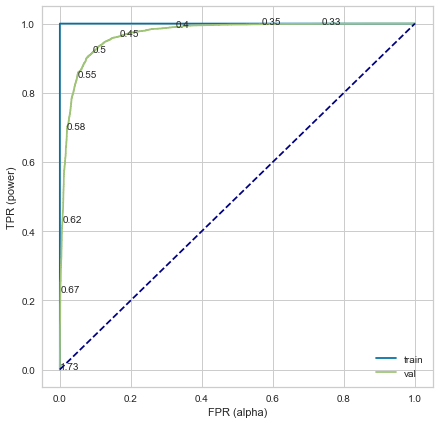

In [60]:
adaboost_dtree.get_scores({}, skf)

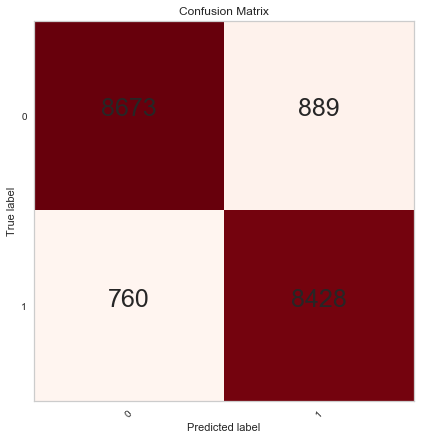

In [61]:
adaboost_dtree.show_conf_matrix()

### AdaBoost Applied to Random Forest

In [62]:
estimators = ran_forest2.best_model
adaboost_ran_forest = Ensemble("AdaBoost", estimators, X_train_s, X_val_s, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,AdaBoost,1.0,0.9526


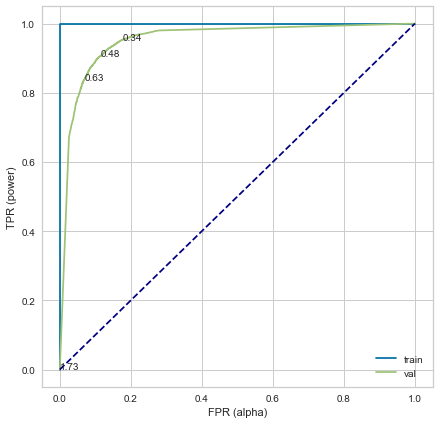

In [63]:
adaboost_ran_forest.get_scores({}, skf)

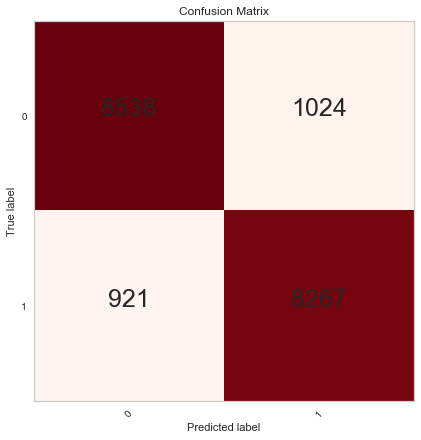

In [64]:
adaboost_ran_forest.show_conf_matrix()

## XGBoost Classifier

In [65]:
estimators = []
xgboost = Ensemble("XGBoost", estimators, X_train_s, X_val_s, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,XGBoost,0.962,0.9378


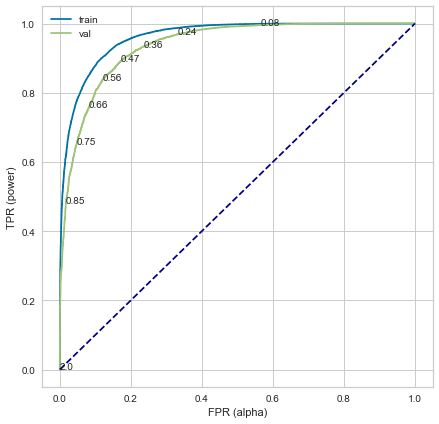

In [66]:
xgboost.get_scores({}, skf)

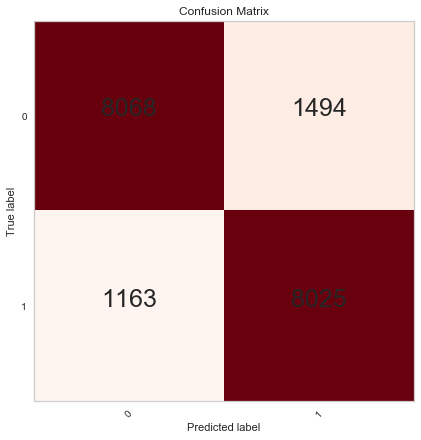

In [67]:
xgboost.show_conf_matrix()

## Voting Classifier

In [68]:
dtree_best = ('ada_dtree', adaboost_dtree.best_model)
rand_forest = ('rnd', ran_forest2.best_model)
estimators = [dtree_best,rand_forest]

In [69]:
voting = Ensemble("Voting", estimators, X_train_s, X_val_s, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,Voting,1.0,0.9703


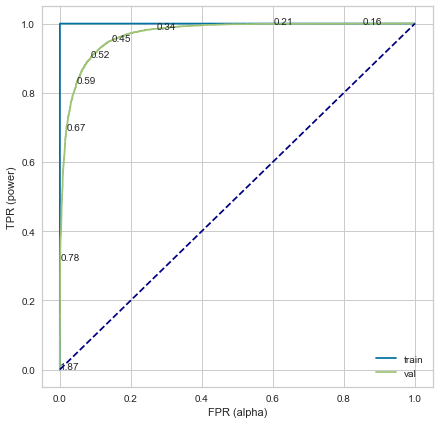

In [70]:
voting.get_scores({}, skf)

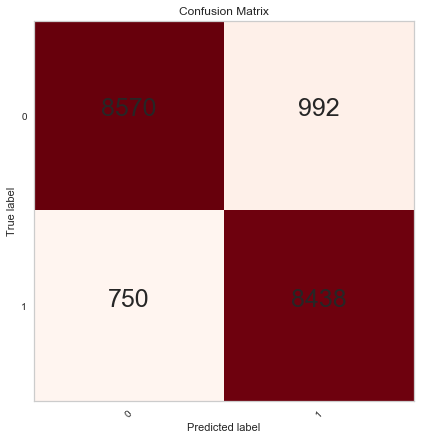

In [71]:
voting.show_conf_matrix()

## Stacking Classifier

In [72]:
dtree_best = ('ada_dtree', adaboost_dtree.best_model)
rand_forest = ('rnd', ran_forest2.best_model)
estimators = [dtree_best,rand_forest]
stacking = Ensemble("Stacking", estimators, X_train_s, X_val_s, y_train, y_val)

,Model Name,Train AUC,Validation AUC
0,Stacking,1.0,0.974


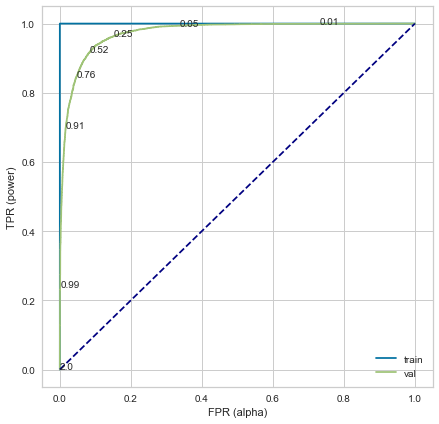

In [73]:
stacking.get_scores({}, skf)

## Model Selection

In [74]:
all_models = pd.concat([baseline.scores_table,
                       logistic4.scores_table,
                       dtree3.scores_table,
                       ran_forest2.scores_table,
                       adaboost_log_reg.scores_table,
                       adaboost_dtree.scores_table,
                       adaboost_ran_forest.scores_table,
                       xgboost.scores_table,
                       voting.scores_table,
                       stacking.scores_table],
                       axis=0)

In [75]:
all_models

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.8002,0.7983
0,Logistic Regression,0.8007,0.7987
0,Decision Tree,0.9762,0.9094
0,Random Forest,1.0000,0.9622
0,AdaBoost,0.7719,0.7678
0,AdaBoost,1.0000,0.9696
0,AdaBoost,1.0000,0.9526
0,XGBoost,0.9620,0.9378
0,Voting,1.0000,0.9703
0,Stacking,1.0000,0.9740


## Threshold Selection

In [76]:
adaboost_dtree.threshold_calculator()

,Threshold,TPR,FPR,fm
2035,0.532872,0.857967,0.050931,0.754837
2041,0.529943,0.858620,0.051349,0.754643
2039,0.530462,0.858402,0.051245,0.754637
2045,0.529547,0.859164,0.051663,0.754552
2037,0.531018,0.858076,0.051140,0.754522


## Testing Model

,Model Name,Train AUC,Validation AUC
0,AdaBoost,1.0,0.9704


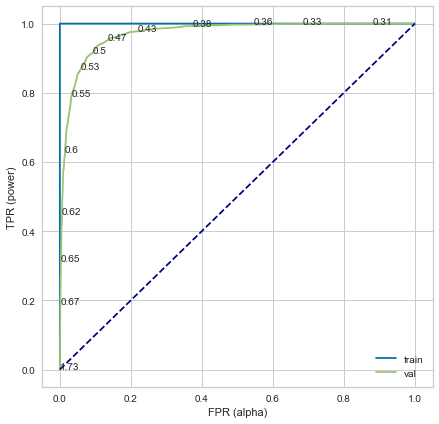

In [77]:
adaboost_dtree.get_test_scores(X_test_S,y_test)

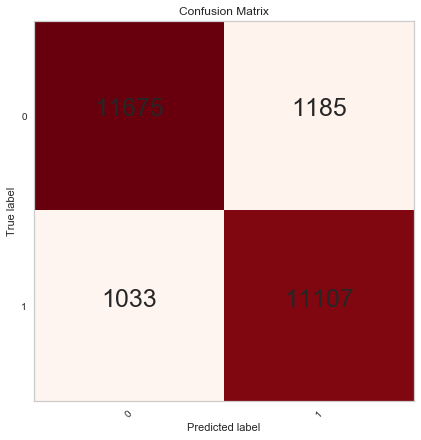

In [78]:
adaboost_dtree.show_test_conf_matrix()

# Evaluation

## Feature Importances

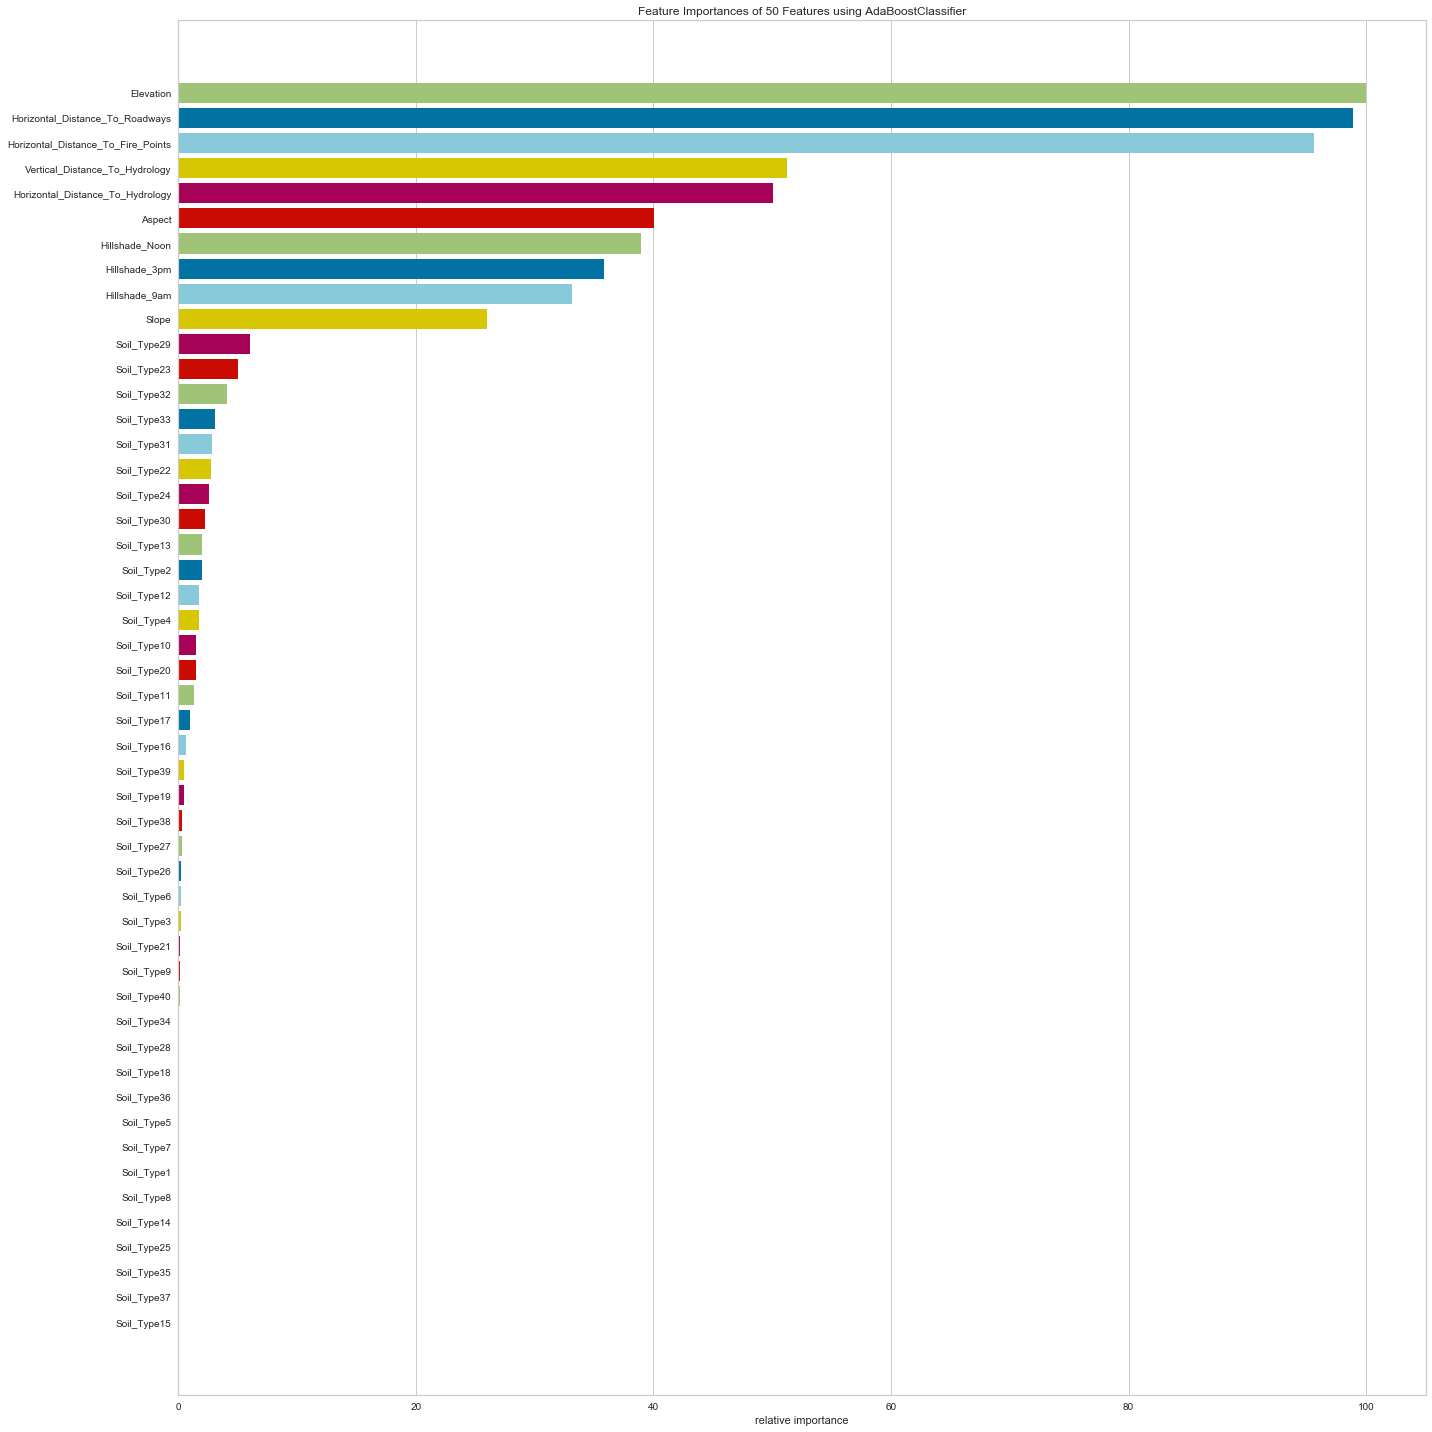

<Figure size 432x288 with 0 Axes>

In [79]:
plt.figure(figsize=(20,20))
feature_importances(adaboost_dtree.best_model,X_train_s, y_train)
plt.savefig('./bestmodel_feature_importance.png')
plt.show()